Librerias

In [173]:
import os
import scipy.io
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

#CNN
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np

In [174]:
ruta = "datos mat\Done"

In [175]:
# Parámetros del modelo
input_shape=(385,16)
optimizer_params = {
    'learning_rate': 0.001,    'beta_1': 0.9,    'beta_2': 0.999,    'epsilon': 1e-07,
    'amsgrad': False,    'weight_decay': None,    'clipnorm': None,    'clipvalue': None,
    'global_clipnorm': None,
    'use_ema': False,
    'ema_momentum': 0.99,
    'ema_overwrite_frequency': None,
    'loss_scale_factor': None,
    'gradient_accumulation_steps': None,
    'name': "adam"
}

Funciones

In [176]:
#Obtener los eventos
def get_egg_processed_t(ruta_evento):
    # Cargar datos desde el archivo .mat
    mat_data = loadmat(ruta_evento)

    # Obtener 'eeg_processed' del diccionario cargado
    eeg_processed = mat_data.get('eeg_processed')
    eeg_processed_tensor = tf.convert_to_tensor(eeg_processed)

    return eeg_processed_tensor

In [177]:
def get_event_sujxrun(ruta, sujeto):
    eventos_por_mark = {}

    for subject in os.listdir(ruta):
        if f"Subject {sujeto}" in subject:
            ruta_subj = os.path.join(ruta, subject)
            archivos_suj = os.listdir(ruta_subj)

            for run in range(1, 7):  # Iterar sobre los 6 runs
                for suj in archivos_suj:
                    if f"run_{run}" in suj:  # Corregido para iterar sobre todos los runs
                        ruta_suj = os.path.join(ruta_subj, suj)
                        archivos_mark = os.listdir(ruta_suj)

                        for mark in archivos_mark:
                            ruta_mark = os.path.join(ruta_suj, mark)
                            archivos_event = os.listdir(ruta_mark)

                            for event in archivos_event:
                                ruta_evento = os.path.join(ruta_mark, event)

                                eeg_processed = get_egg_processed_t(ruta_evento)
                                if eeg_processed.shape != (0, 16):
                                    if mark not in eventos_por_mark:
                                        eventos_por_mark[mark] = []
                                    eventos_por_mark[mark].append(eeg_processed)
                                    
   
    return eventos_por_mark 

In [178]:
def datos_x_suj(suj):
    events_suj = get_event_sujxrun(ruta, f"{suj}")
    markers = {"Marker_1": [], "Marker_2": [], "Marker_3": [], "Marker_4": [], "Marker_5": [], "Marker_6": []}
    length_datos = {mark: 0 for mark in events_suj}
    
    for mark, value in events_suj.items():
        if mark in markers:
            markers[mark].extend(value)  
            length_datos[mark] += len(value)
    
    tensorxsuj={}
    
    for key, value in markers.items():
        tensorxsuj[key] = tf.reshape(tf.convert_to_tensor(value), (length_datos[key], 385, 16))
        
    return tensorxsuj, length_datos

In [179]:
def agrupar_all_suj():
    all_markers = None
    all_lengths = {}
    
    for suj in range(1, 7):
        tensorxsuj, length_datos = datos_x_suj(suj)
        
        for marker, tensor in tensorxsuj.items():
            if all_markers is None:
                all_markers = tensor
            else:
                all_markers = tf.concat([all_markers, tensor], axis=0)
            if marker in all_lengths:
                all_lengths[marker] += length_datos[marker]
            else:
                all_lengths[marker] = length_datos[marker]
    
    return all_markers, all_lengths

In [180]:
all_markers, all_lengths = agrupar_all_suj()
print(all_markers.shape)
print(all_lengths)

(2227, 385, 16)
{'Marker_1': 331, 'Marker_2': 393, 'Marker_3': 414, 'Marker_4': 402, 'Marker_5': 392, 'Marker_6': 295}


In [181]:
def get_labels_ohc(marker,length_datos):
    # Valores por clase
    valores = {"Marker_1": 0, "Marker_2": 1, "Marker_3": 2, "Marker_4": 3, "Marker_5": 4, "Marker_6": 5}
    
    # Obtener el valor correspondiente al marcador
    n = valores[f"{marker}"]
    
    # Codificar las etiquetas utilizando one-hot encoding
    one_hot_labels = tf.one_hot(indices=n, depth=6)  # 6 es el número de clases
    
    # Expandir las dimensiones para tener la forma (length_datos, 6)
    expanded_labels = tf.expand_dims(one_hot_labels, axis=0)
    expanded_labels = tf.tile(expanded_labels, [length_datos, 1])
    
    return expanded_labels

In [182]:
def all_labels():
    n_label=[]
    for marker, value in all_lengths.items():
        label_marker= get_labels_ohc(marker, value)
        n_label.append(label_marker)
    
    return tf.concat(n_label, axis=0)

In [183]:
labels_usar= all_labels()
inputs_usar= all_markers

MODELO CONV1D

In [184]:
from keras.optimizers import Adam

def conv1d_model(input_shape):
    optimizer = Adam(**optimizer_params)

    model = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(2),
        layers.Conv1D(32, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [185]:
model = conv1d_model(input_shape)


In [186]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 383, 64)        │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 191, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 189, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 94, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3008)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       192,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,278 (790.15 KB)

 Trainable params: 202,278 (790.15 KB)

 Non-trainable params: 0 (0.00 B)

In [187]:
import numpy as np
from sklearn.model_selection import train_test_split

train_inputs_numpy = inputs_usar.numpy()
train_labels_numpy = labels_usar.numpy()

# Dividir los datos en conjuntos de entrenamiento y prueba
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    train_inputs_numpy, train_labels_numpy, test_size=0.2)


In [188]:
# Entrenamiento del modelo
history = model.fit(train_inputs, train_labels, epochs=50, batch_size=16, validation_data=(val_inputs, val_labels))

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2871 - loss: 1.6496 - val_accuracy: 0.5650 - val_loss: 1.1006
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6311 - loss: 0.9275 - val_accuracy: 0.6211 - val_loss: 0.9069
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7411 - loss: 0.6428 - val_accuracy: 0.6345 - val_loss: 0.7521
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7597 - loss: 0.5571 - val_accuracy: 0.6749 - val_loss: 0.6577
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8387 - loss: 0.4337 - val_accuracy: 0.6726 - val_loss: 0.7255
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8544 - loss: 0.3791 - val_accuracy: 0.6951 - val_loss: 0.7289
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8927 - loss: 0.2978 - val_accuracy: 0.6749 - val_loss: 0.7839
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9063 - loss: 0.2720 - val_accuracy: 0.

In [189]:
# Entrenamiento del modelo shuffle=True
history_s = model.fit(train_inputs, train_labels, epochs=50, batch_size=16,shuffle=True,validation_data=(val_inputs, val_labels))

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.5742e-04 - val_accuracy: 0.7018 - val_loss: 1.7067
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.4583e-04 - val_accuracy: 0.6996 - val_loss: 1.7223
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.3423e-04 - val_accuracy: 0.7085 - val_loss: 1.7308
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.2299e-04 - val_accuracy: 0.7018 - val_loss: 1.7551
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.2051e-04 - val_accuracy: 0.6973 - val_loss: 1.7517
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.1214e-04 - val_accuracy: 0.7018 - val_loss: 1.7715
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.0698e-04 - val_accuracy: 0.7018 - val_loss: 1.7843
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - los

In [190]:
def plot_training_history(history, history_s):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

    # Plot training & validation accuracy values from history
    ax1.plot(history.history['accuracy'], label='Train (No Shuffle)', color='blue')
    ax1.plot(history.history['val_accuracy'], label='Val (No Shuffle)', color='green')
    ax1.set_title('Model Accuracy (No Shuffle)')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper left')

    # Plot training & validation accuracy values from history_s
    ax2.plot(history_s.history['accuracy'], label='Train (Shuffle)', color='red')
    ax2.plot(history_s.history['val_accuracy'], label='Val (Shuffle)', color='orange')
    ax2.set_title('Model Accuracy (Shuffle)')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Plot training & validation loss values from history
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(8, 3))

    # Plot training & validation loss values from history
    ax3.plot(history.history['loss'], label='Train (No Shuffle)', color='blue')
    ax3.plot(history.history['val_loss'], label='Val (No Shuffle)', color='green')
    ax3.set_title('Model Loss (No Shuffle)')
    ax3.set_ylabel('Loss')
    ax3.set_xlabel('Epoch')
    ax3.legend(loc='upper left')

    # Plot training & validation loss values from history_s
    ax4.plot(history_s.history['loss'], label='Train (Shuffle)', color='red')
    ax4.plot(history_s.history['val_loss'], label='Val (Shuffle)', color='orange')
    ax4.set_title('Model Loss (Shuffle)')
    ax4.set_ylabel('Loss')
    ax4.set_xlabel('Epoch')
    ax4.legend(loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()


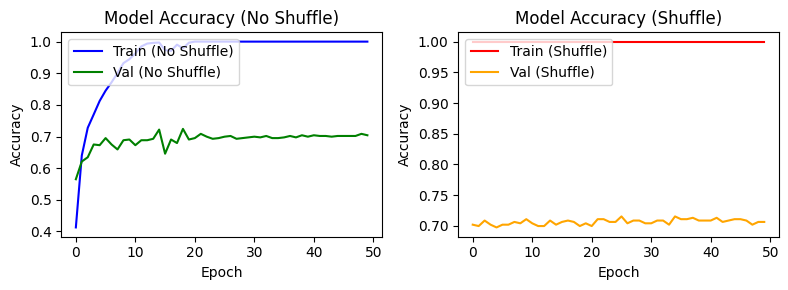

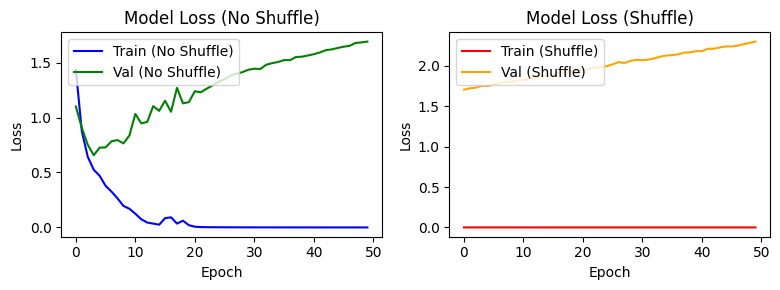

In [191]:
plot_training_history(history, history_s)

In [193]:
test_loss, test_accuracy = model.evaluate(val_inputs, val_labels) #rendimiento del modelo
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7320 - loss: 2.3302
Test accuracy: 0.7062780261039734
Test loss: 2.300757884979248
